## 1. 분석환경 구축 

### 1.1 Colab 구글 드라이브 연동

In [ ]:
# 구글 Colaboratory 를 사용하기 위해 구글 계정으로 로그인합니다. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import time 
import datetime

# One Hot Encoding 라이브러리
from sklearn.preprocessing import OneHotEncoder

# EDA 용 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as font
import seaborn as sns

# 모델링을 위한 라이브러리
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Data Augmentation 을 위한 라이브러리
from imblearn.over_sampling import SMOTE

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

['/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Itali

### 1.3. 랜덤시드 고정

In [ ]:
# 랜덤시드 고정
RANDOM_SEED = 11

## 2. 데이터 로딩

### 2.1. 데이터 파일 열기

데이터 is AICONNECT에서 2기 이어드림 1차 모의 경진대회

In [ ]:
# 구글 드라이브 내 데이터가 위치한 경로를 설정합니다.
path = '/content/drive/MyDrive/YDS1char/'

# 학습용 데이터 파일
data = pd.read_csv(f'{path}Data/Train_RS_Yeardream.csv', encoding='utf-8')

# 평가용 데이터 파일
test = pd.read_csv(f'{path}Data/Test.csv', encoding='utf-8')

# 제출용 파일
submit = pd.read_csv(f'{path}Data/Sample_Submission.csv', encoding='utf-8')

# 데이터의 column을 잘 변경해봅시다.
data = data.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)

# NaN이 있을 경우 일부 함수(.str.contains 등등)가 작동되지 않으므로 '작성되지 않은 칸'으로 대체한다.
data = data.fillna('작성되지 않은 칸')
test = test.fillna('작성되지 않은 칸')

### 2.2. 데이터 확인

In [ ]:
data.shape

(8307, 18)

In [ ]:
data.head()

,식당ID,식당이름,주소,메뉴,영업시간,평점,AI산출점수,지역,좋아요 수,주요품목,방문목적,시설,리뷰_작성자,총평,맛평점,가격평점,서비스평점,텍스트
0,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",작성되지 않은 칸,24569,1.0,3.0,1.0,1.0,세상살다 이렇게 불친절 끝판왕인 식당은 처음보네요!!\n\n\n불친절 풀코스 체험기...
1,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",작성되지 않은 칸,71433,1.0,5.0,3.0,1.0,다시는 안감\n\n(음식은 맛있음)
2,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",작성되지 않은 칸,98352,4.0,3.0,5.0,3.0,집밥을 향해 돌진하는 방배 마을 회관 같은 식당. 언제든 들려 한 끼 푸짐한 밥을 ...
3,82,10 꼬르소꼬모 카페,서울특별시 강남구 압구정로 416,"[{'menu': '후루티 디 마레 카펠리니', 'price': '49000'}, ...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.3,53,청담,77.0,"카페,밀크티빙수","데이트,소개팅","발렛가능,발렛",62074,4.0,5.0,3.0,5.0,이색적인 인테리어가 특유의 고급스러운 분위기를 살려주는 카페 겸 식당. 테이블 마다...
4,140,101번지 남산돈까스,서울특별시 중구 소파로 101(남산동2가),"[{'menu': '남산왕돈까스', 'price': '10500'}, {'menu'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.4,58,남산,137.0,"돈까스,왕돈까스","데이트,가족외식","발렛,셀프바,지역화폐",95119,5.0,5.0,5.0,3.0,진짜 큰 돈까스!!왕 크고 얇아서 경양식 돈까스로 딱!!! 스프도 같이 나오고 고추...


In [ ]:
test.shape

(711, 15)

In [ ]:
test.head()

,식당ID,식당이름,주소,메뉴,영업시간,평점,AI산출점수,지역,좋아요 수,주요품목,방문목적,시설,리뷰_작성자,총평,Answer_ID
0,38,03수제비칼국수,서울특별시 서초구 방배중앙로27길 9(방배동),"[{'menu': '제육볶음(2인분 이상)', 'price': '8000'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.6,42,방배동,16.0,"청국장,오징어볶음","식사모임,혼밥",작성되지 않은 칸,94354,0,94354_38
1,370,128판,서울특별시 종로구 동숭4길 14,"[{'menu': '마레', 'price': '12000'}, {'menu': '풍...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.5,52,혜화,18.0,"파스타,풍기리조또","데이트,기념일",예약필수,63420,0,63420_370
2,2155,37.5,서울특별시 서초구 서래로7길 16,"[{'menu': '정통 아메리칸 브런치', 'price': '17900'}, {'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",3.2,38,서래마을,16.0,"브런치카페,브런치","데이트,모임",발렛,81264,0,81264_2155
3,2513,4브라더스,서울특별시 강남구 논현로28길 40,"[{'menu': '안심 쌀국수', 'price': '11500'}, {'menu'...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.3,68,도곡,164.0,"쌀국수,월남쌈","가족외식,모임장소",발렛,58332,0,58332_2513
4,8415,e모네 춘천닭갈비,서울특별시 서초구 반포대로22길 89,"[{'menu': '닭갈비', 'price': '10000'}, {'menu': '...","{'open_hour': [{'day': ['월', '화', '수', '목', '금...",4.2,49,교대역,15.0,"닭갈비,닭갈비덮밥","식사모임,모임",작성되지 않은 칸,80349,0,80349_8415


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8307 entries, 0 to 8306
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   식당ID    8307 non-null   int64  
 1   식당이름    8307 non-null   object 
 2   주소      8307 non-null   object 
 3   메뉴      8307 non-null   object 
 4   영업시간    8307 non-null   object 
 5   평점      8307 non-null   float64
 6   AI산출점수  8307 non-null   int64  
 7   지역      8307 non-null   object 
 8   좋아요 수   8307 non-null   object 
 9   주요품목    8307 non-null   object 
 10  방문목적    8307 non-null   object 
 11  시설      8307 non-null   object 
 12  리뷰_작성자  8307 non-null   int64  
 13  총평      8307 non-null   float64
 14  맛평점     8307 non-null   float64
 15  가격평점    8307 non-null   float64
 16  서비스평점   8307 non-null   float64
 17  텍스트     8307 non-null   object 
dtypes: float64(5), int64(3), object(10)
memory usage: 1.1+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   식당ID       711 non-null    int64  
 1   식당이름       711 non-null    object 
 2   주소         711 non-null    object 
 3   메뉴         711 non-null    object 
 4   영업시간       711 non-null    object 
 5   평점         711 non-null    float64
 6   AI산출점수     711 non-null    int64  
 7   지역         711 non-null    object 
 8   좋아요 수      711 non-null    object 
 9   주요품목       711 non-null    object 
 10  방문목적       711 non-null    object 
 11  시설         711 non-null    object 
 12  리뷰_작성자     711 non-null    int64  
 13  총평         711 non-null    int64  
 14  Answer_ID  711 non-null    object 
dtypes: float64(1), int64(4), object(10)
memory usage: 83.4+ KB


## 3. 내가 생각하는 대로 EDA

In [ ]:
eda_df = data.copy() # 오리지널 파일에서 EDA 용 데이터프레임 별도 생성함.

### 3.1. 식당 이름에 대한 sort

In [ ]:
# train 데이터에서 식당 이름이 같은 것끼리 잘 정리되었는지(=sort 되었는지)를 체크해보았다.
# a is 서로 다른 식당 이름 개수, b is 식당 이름 column을 처음부터 끝까지 긁어보면서 the_name과 다르다면 +1(이름이 달라지는 것)

a = eda_df['식당이름'].nunique()
b = 0
the_name = '03수제비칼국수'
for i in range(len(eda_df)):
    if the_name != eda_df['식당이름'][i]:
        b += 1
    the_name = eda_df['식당이름'][i]
print(a)
print(b)

2510
2589


train 데이터의 식당 이름은 sort가 안 된 것을 관찰

### 3.2. 체인점 검사

In [ ]:
# train 데이터에서 식당 이름이 같으면서 ID는 다른 게 있다. so this is 체인점.
# 어떤 식당 이름을 가져와서 그것이 체인점을 가졌는지와 어떻게 가지고 있는가를 검사한다.
# 유의미해지기 위해 '그것의 개수'를 25 이상으로 잡아본다.

for i in eda_df['식당이름'].unique():
    if (eda_df['식당이름'] == i).sum() >= 25:
        if eda_df[eda_df['식당이름'] == i]['식당ID'].nunique() >= 2:
            j = (eda_df['식당이름'] == i).sum()
            k = eda_df[eda_df['식당이름'] == i]['식당ID'].nunique()
            print('체인점 펼친 식당 : {}, 그것의 개수 : {}, 서로 다른 체인점 : {}'.format(i, j, k))

체인점 펼친 식당 : 다운타우너, 그것의 개수 : 33, 서로 다른 체인점 : 3
체인점 펼친 식당 : 명동교자, 그것의 개수 : 74, 서로 다른 체인점 : 2
체인점 펼친 식당 : 스타벅스, 그것의 개수 : 124, 서로 다른 체인점 : 42
체인점 펼친 식당 : 폴바셋, 그것의 개수 : 27, 서로 다른 체인점 : 8


몇몇 가게들은 체인점이 장난 아닌게 있다. 이것을 주목해보자.

### 3.3. 식당 평가가 많이 이루어진 지역

In [ ]:
# 지역 이름마다 그 개수를 계산하는데, 유의미해지기 위해 그 숫자가 200 이상인 것만 뽑아보자.

for i in eda_df['지역'].unique():
    if (eda_df['지역'] == i).sum() >= 200:
        print(f'지역 {i} 개수', (eda_df['지역'] == i).sum())

지역 청담 개수 332
지역 코엑스 개수 242
지역 강남역 개수 727
지역 가로수길 개수 354
지역 압구정 개수 423
지역 강남 개수 428


100개를 넘는 지역이 몇 개 있는 것을 관찰

### 3.4. 식당 ID 같은데 주소/메뉴/영업시간/평점/AI산출/지역/좋아요 수/주요품목/시설 다른 경우가 있을까?

In [ ]:
# 어떤 ID에 대해 다음을 계산한다.
# 하나라도 틀리면 Black_Bun이 1 되고 Black_List가 됩니다.

Black_List = []
for i in eda_df['식당ID'].unique():
    if (eda_df['식당ID'] == i).sum() >= 2:
        Black_Bun = 0
        if eda_df[eda_df['식당ID'] == i]['식당이름'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['주소'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['메뉴'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['영업시간'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['평점'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['AI산출점수'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['지역'].nunique() != 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['좋아요 수'].nunique() > 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['주요품목'].nunique() > 1:
            Black_Bun = 1
        if eda_df[eda_df['식당ID'] == i]['시설'].nunique() > 1:
            Black_Bun = 1
        if Black_Bun == 1:
            Black_List.append(i)
for broker in Black_List:
    print('{} ID 가진 식당 데이터 저장한 ㅅㄲ 누구냐'.format(broker))
if len(Black_List) > 0:
    print('그 외는 정상입니다.')
else:
    print('야 이거 저장한 분 잘하셨네')

야 이거 저장한 분 잘하셨네


완벽하네요. 이제 데이터 내부에서 의심할 부분은 없게 되었습니다.

### 3.5. 그래프

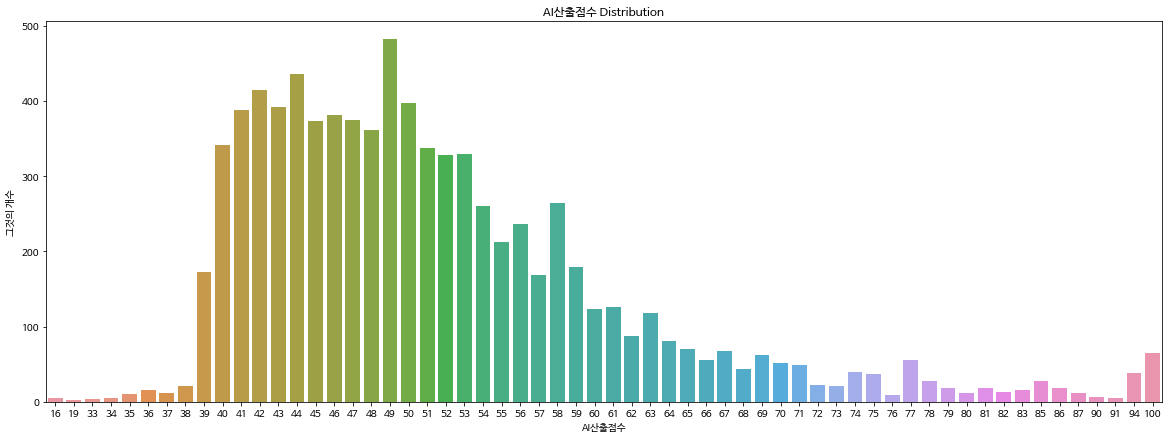

In [ ]:
# AI 산출 점수가 어떻게 되었는가?

fig = plt.figure(figsize=(20, 7))
sns.countplot(x='AI산출점수', data=eda_df)
plt.title('AI산출점수 Distribution')
plt.xlabel('AI산출점수')
plt.ylabel('그것의 개수')
plt.show()

인공지능은 40점 ~ 60점 위주로 평가했다.

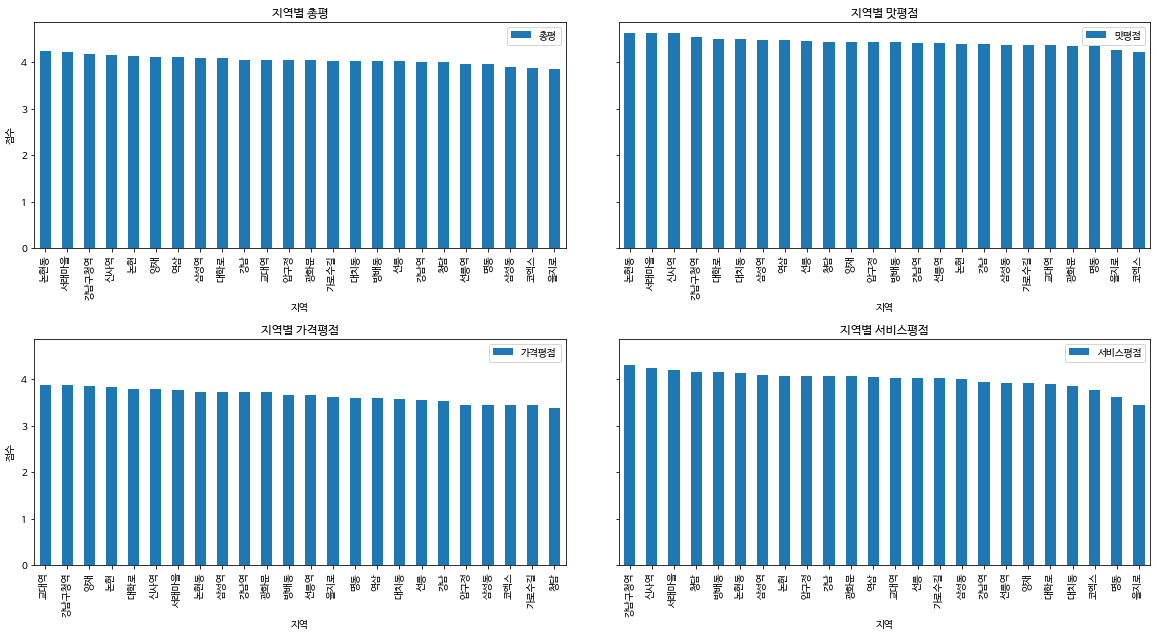

In [ ]:
# 100건 이상의 평가가 이루어진 지역을 기준으로 평점 평균이 어떻게 되었는지 알아보자.

Graph_for_Location_지역 = []
Graph_for_Location_총평 = []
Graph_for_Location_맛평점 = []
Graph_for_Location_가격평점 = []
Graph_for_Location_서비스평점 = []

for i in eda_df['지역'].unique():
    if (eda_df['지역'] == i).sum() >= 100:
        Graph_for_Location_지역.append(i)
        Graph_for_Location_총평.append(eda_df[eda_df['지역'] == i]['총평'].sum() / (eda_df['지역'] == i).sum())
        Graph_for_Location_맛평점.append(eda_df[eda_df['지역'] == i]['맛평점'].sum() / (eda_df['지역'] == i).sum())
        Graph_for_Location_가격평점.append(eda_df[eda_df['지역'] == i]['가격평점'].sum() / (eda_df['지역'] == i).sum())
        Graph_for_Location_서비스평점.append(eda_df[eda_df['지역'] == i]['서비스평점'].sum() / (eda_df['지역'] == i).sum())

Visual_Object = pd.DataFrame({'지역':Graph_for_Location_지역,
                            '총평':Graph_for_Location_총평,
                            '맛평점':Graph_for_Location_맛평점,
                            '가격평점':Graph_for_Location_가격평점,
                            '서비스평점':Graph_for_Location_서비스평점})

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(40, 20))
fig.subplots_adjust(hspace=.4, wspace=.1)

Visual_Object.sort_values(by=['총평'],ascending=False).plot.bar(x='지역', y='총평', rot=90, figsize=(20, 10), ax=axes[0][0])
axes[0][0].set_title('지역별 총평')
axes[0][0].set_xlabel('지역')
axes[0][0].set_ylabel('점수')

Visual_Object.sort_values(by=['맛평점'],ascending=False).plot.bar(x='지역', y='맛평점', rot=90, figsize=(20, 10), ax=axes[0][1])
axes[0][1].set_title('지역별 맛평점')
axes[0][1].set_xlabel('지역')
axes[0][1].set_ylabel('점수')

Visual_Object.sort_values(by=['가격평점'],ascending=False).plot.bar(x='지역', y='가격평점', rot=90, figsize=(20, 10), ax=axes[1][0])
axes[1][0].set_title('지역별 가격평점')
axes[1][0].set_xlabel('지역')
axes[1][0].set_ylabel('점수')

Visual_Object.sort_values(by=['서비스평점'],ascending=False).plot.bar(x='지역', y='서비스평점', rot=90, figsize=(20, 10), ax=axes[1][1])
axes[1][1].set_title('지역별 서비스평점')
axes[1][1].set_xlabel('지역')
axes[1][1].set_ylabel('점수')

plt.show()

인기있는 지역 24곳에 있는 식당들의 평점을 평균내었더니 위와 같다. 근데 하나같이 3.5점 ~ 4.5점이다. 그렇다면 세부적인 개수는 어떨까?

In [ ]:
# 100건 이상의 평가가 이루어진 지역을 기준으로 평점마다 개수가 어떻게 되었는지 표로 알아보자.

Graph_for_Location_지역 = []
Graph_for_Location_총평_1 = []
Graph_for_Location_총평_2 = []
Graph_for_Location_총평_3 = []
Graph_for_Location_총평_4 = []
Graph_for_Location_총평_5 = []
Graph_for_Location_맛평점_1 = []
Graph_for_Location_가격평점_1 = []
Graph_for_Location_서비스평점_1 = []
Graph_for_Location_맛평점_3 = []
Graph_for_Location_가격평점_3 = []
Graph_for_Location_서비스평점_3 = []
Graph_for_Location_맛평점_5 = []
Graph_for_Location_가격평점_5 = []
Graph_for_Location_서비스평점_5 = []

for i in eda_df['지역'].unique():
    if (eda_df['지역'] == i).sum() >= 100:
        Graph_for_Location_지역.append(i)
        Graph_for_Location_총평_1.append(((eda_df['지역'] == i) & (eda_df['총평'] == 1.0)).sum())
        Graph_for_Location_총평_2.append(((eda_df['지역'] == i) & (eda_df['총평'] == 2.0)).sum())
        Graph_for_Location_총평_3.append(((eda_df['지역'] == i) & (eda_df['총평'] == 3.0)).sum())
        Graph_for_Location_총평_4.append(((eda_df['지역'] == i) & (eda_df['총평'] == 4.0)).sum())
        Graph_for_Location_총평_5.append(((eda_df['지역'] == i) & (eda_df['총평'] == 5.0)).sum())
        Graph_for_Location_맛평점_1.append(((eda_df['지역'] == i) & (eda_df['맛평점'] == 1.0)).sum())
        Graph_for_Location_맛평점_3.append(((eda_df['지역'] == i) & (eda_df['맛평점'] == 3.0)).sum())
        Graph_for_Location_맛평점_5.append(((eda_df['지역'] == i) & (eda_df['맛평점'] == 5.0)).sum())
        Graph_for_Location_가격평점_1.append(((eda_df['지역'] == i) & (eda_df['가격평점'] == 1.0)).sum())
        Graph_for_Location_가격평점_3.append(((eda_df['지역'] == i) & (eda_df['가격평점'] == 3.0)).sum())
        Graph_for_Location_가격평점_5.append(((eda_df['지역'] == i) & (eda_df['가격평점'] == 5.0)).sum())
        Graph_for_Location_서비스평점_1.append(((eda_df['지역'] == i) & (eda_df['서비스평점'] == 1.0)).sum())
        Graph_for_Location_서비스평점_3.append(((eda_df['지역'] == i) & (eda_df['서비스평점'] == 3.0)).sum())
        Graph_for_Location_서비스평점_5.append(((eda_df['지역'] == i) & (eda_df['서비스평점'] == 5.0)).sum())

Visual_Object = pd.DataFrame({'지역':Graph_for_Location_지역,
                            '총평_1':Graph_for_Location_총평_1,
                            '총평_2':Graph_for_Location_총평_2,
                            '총평_3':Graph_for_Location_총평_3,
                            '총평_4':Graph_for_Location_총평_4,
                            '총평_5':Graph_for_Location_총평_5,
                            '맛평점_1':Graph_for_Location_맛평점_1,
                            '맛평점_3':Graph_for_Location_맛평점_3,
                            '맛평점_5':Graph_for_Location_맛평점_5,
                            '가격평점_1':Graph_for_Location_가격평점_1,
                            '가격평점_3':Graph_for_Location_가격평점_3,
                            '가격평점_5':Graph_for_Location_가격평점_5,
                            '서비스평점_1':Graph_for_Location_서비스평점_1,
                            '서비스평점_3':Graph_for_Location_서비스평점_3,
                            '서비스평점_5':Graph_for_Location_서비스평점_5})
Visual_Object

,지역,총평_1,총평_2,총평_3,총평_4,총평_5,맛평점_1,맛평점_3,맛평점_5,가격평점_1,가격평점_3,가격평점_5,서비스평점_1,서비스평점_3,서비스평점_5
0,방배동,5,3,14,53,38,4,24,85,6,63,44,3,42,68
1,청담,4,13,63,147,105,7,78,247,39,189,104,8,124,200
2,강남구청역,0,2,23,76,57,0,36,122,8,73,77,1,53,104
3,코엑스,4,4,71,103,60,9,76,157,28,132,82,10,129,103
4,교대역,1,5,20,43,39,1,32,75,7,46,55,4,44,60
5,을지로,0,6,37,55,31,1,45,83,11,67,51,7,86,36
6,대학로,1,4,19,78,44,1,34,111,9,70,67,4,72,70
7,강남역,9,17,159,312,230,16,179,532,50,360,317,25,334,368
8,가로수길,10,11,51,167,115,11,89,254,36,204,114,11,150,193
9,압구정,3,14,73,201,132,8,102,313,44,239,140,15,164,244


청담동, 강남, 압구정은 비싸구나

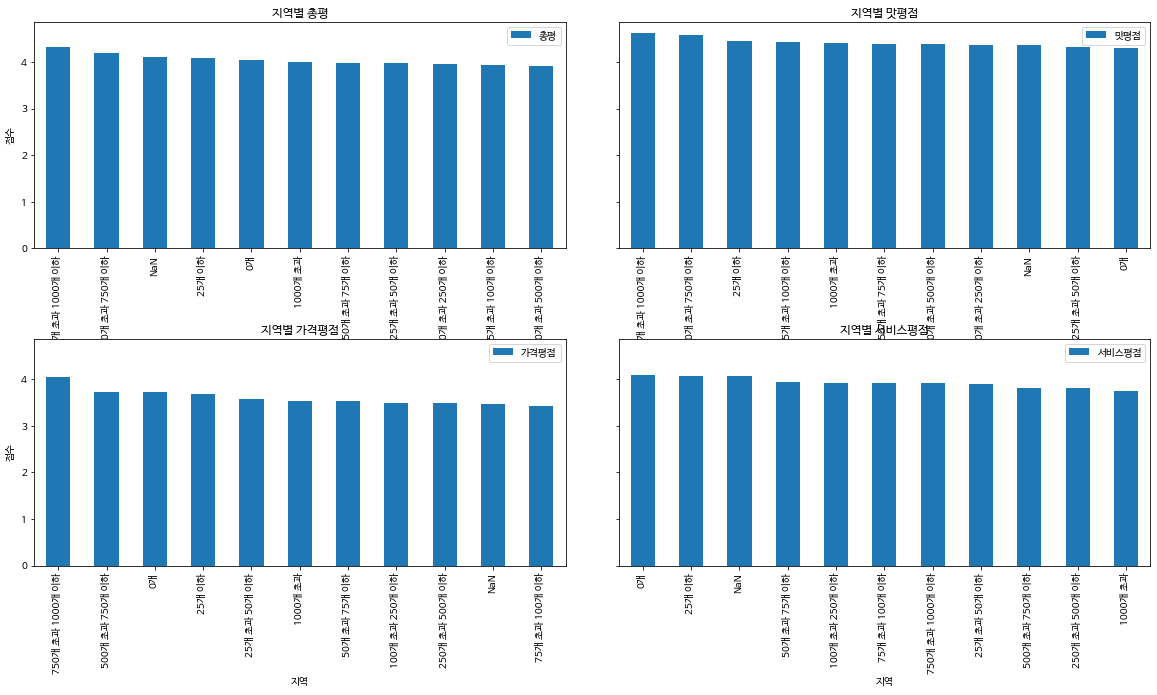

In [ ]:
def func(x):
    if x == 0:
        return "0개"
    elif x <= 25:
        return "25개 이하"
    elif x <= 50:
        return "25개 초과 50개 이하"
    elif x <= 75:
        return "50개 초과 75개 이하"
    elif x <= 100:
        return "75개 초과 100개 이하"
    elif x <= 250:
        return "100개 초과 250개 이하"
    elif x <= 500:
        return "250개 초과 500개 이하"
    elif x <= 750:
        return "500개 초과 750개 이하"
    elif x <= 1000:
        return "750개 초과 1000개 이하"
    elif x > 1000:
        return "1000개 초과"
    else:
        return "NaN"
eda_df['좋아요의 범위'] = (eda_df['좋아요 수']).apply(func)

Graph_for_zot_zotgayo = []
Graph_for_zot_총평 = []
Graph_for_zot_맛평점 = []
Graph_for_zot_가격평점 = []
Graph_for_zot_서비스평점 = []
for i in ['0개', "25개 이하", "25개 초과 50개 이하", "50개 초과 75개 이하", "75개 초과 100개 이하", "100개 초과 250개 이하",
          "250개 초과 500개 이하", "500개 초과 750개 이하", "750개 초과 1000개 이하", "1000개 초과", "NaN"]:
    Graph_for_zot_zotgayo.append(i)
    Graph_for_zot_총평.append(eda_df[eda_df['좋아요의 범위'] == i]['총평'].sum() / (eda_df['좋아요의 범위'] == i).sum())
    Graph_for_zot_맛평점.append(eda_df[eda_df['좋아요의 범위'] == i]['맛평점'].sum() / (eda_df['좋아요의 범위'] == i).sum())
    Graph_for_zot_가격평점.append(eda_df[eda_df['좋아요의 범위'] == i]['가격평점'].sum() / (eda_df['좋아요의 범위'] == i).sum())
    Graph_for_zot_서비스평점.append(eda_df[eda_df['좋아요의 범위'] == i]['서비스평점'].sum() / (eda_df['좋아요의 범위'] == i).sum())

Visual_Object = pd.DataFrame({'좋아요의 범위':Graph_for_zot_zotgayo,
                            '총평':Graph_for_zot_총평,
                            '맛평점':Graph_for_zot_맛평점,
                            '가격평점':Graph_for_zot_가격평점,
                            '서비스평점':Graph_for_zot_서비스평점})

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(40, 20))
fig.subplots_adjust(hspace=.4, wspace=.1)

Visual_Object.sort_values(by=['총평'],ascending=False).plot.bar(x='좋아요의 범위', y='총평', rot=90, figsize=(20, 10), ax=axes[0][0])
axes[0][0].set_title('지역별 총평')
axes[0][0].set_xlabel('지역')
axes[0][0].set_ylabel('점수')

Visual_Object.sort_values(by=['맛평점'],ascending=False).plot.bar(x='좋아요의 범위', y='맛평점', rot=90, figsize=(20, 10), ax=axes[0][1])
axes[0][1].set_title('지역별 맛평점')
axes[0][1].set_xlabel('지역')
axes[0][1].set_ylabel('점수')

Visual_Object.sort_values(by=['가격평점'],ascending=False).plot.bar(x='좋아요의 범위', y='가격평점', rot=90, figsize=(20, 10), ax=axes[1][0])
axes[1][0].set_title('지역별 가격평점')
axes[1][0].set_xlabel('지역')
axes[1][0].set_ylabel('점수')

Visual_Object.sort_values(by=['서비스평점'],ascending=False).plot.bar(x='좋아요의 범위', y='서비스평점', rot=90, figsize=(20, 10), ax=axes[1][1])
axes[1][1].set_title('지역별 서비스평점')
axes[1][1].set_xlabel('지역')
axes[1][1].set_ylabel('점수')

plt.show()

좋아요 개수는 의미가 없을까?

In [ ]:
# 좋아요 개수를 기준으로 평점마다 개수가 어떻게 되었는지 표로 알아보자.

Graph_for_zot_zotgayo = []
Graph_for_Location_총평_1 = []
Graph_for_Location_총평_2 = []
Graph_for_Location_총평_3 = []
Graph_for_Location_총평_4 = []
Graph_for_Location_총평_5 = []
Graph_for_Location_맛평점_1 = []
Graph_for_Location_가격평점_1 = []
Graph_for_Location_서비스평점_1 = []
Graph_for_Location_맛평점_3 = []
Graph_for_Location_가격평점_3 = []
Graph_for_Location_서비스평점_3 = []
Graph_for_Location_맛평점_5 = []
Graph_for_Location_가격평점_5 = []
Graph_for_Location_서비스평점_5 = []

for i in ['0개', "25개 이하", "25개 초과 50개 이하", "50개 초과 75개 이하", "75개 초과 100개 이하", "100개 초과 250개 이하",
          "250개 초과 500개 이하", "500개 초과 750개 이하", "750개 초과 1000개 이하", "1000개 초과", "NaN"]:
    Graph_for_zot_zotgayo.append(i)
    Graph_for_Location_총평_1.append(((eda_df['좋아요의 범위'] == i) & (eda_df['총평'] == 1.0)).sum())
    Graph_for_Location_총평_2.append(((eda_df['좋아요의 범위'] == i) & (eda_df['총평'] == 2.0)).sum())
    Graph_for_Location_총평_3.append(((eda_df['좋아요의 범위'] == i) & (eda_df['총평'] == 3.0)).sum())
    Graph_for_Location_총평_4.append(((eda_df['좋아요의 범위'] == i) & (eda_df['총평'] == 4.0)).sum())
    Graph_for_Location_총평_5.append(((eda_df['좋아요의 범위'] == i) & (eda_df['총평'] == 5.0)).sum())
    Graph_for_Location_맛평점_1.append(((eda_df['좋아요의 범위'] == i) & (eda_df['맛평점'] == 1.0)).sum())
    Graph_for_Location_맛평점_3.append(((eda_df['좋아요의 범위'] == i) & (eda_df['맛평점'] == 3.0)).sum())
    Graph_for_Location_맛평점_5.append(((eda_df['좋아요의 범위'] == i) & (eda_df['맛평점'] == 5.0)).sum())
    Graph_for_Location_가격평점_1.append(((eda_df['좋아요의 범위'] == i) & (eda_df['가격평점'] == 1.0)).sum())
    Graph_for_Location_가격평점_3.append(((eda_df['좋아요의 범위'] == i) & (eda_df['가격평점'] == 3.0)).sum())
    Graph_for_Location_가격평점_5.append(((eda_df['좋아요의 범위'] == i) & (eda_df['가격평점'] == 5.0)).sum())
    Graph_for_Location_서비스평점_1.append(((eda_df['좋아요의 범위'] == i) & (eda_df['서비스평점'] == 1.0)).sum())
    Graph_for_Location_서비스평점_3.append(((eda_df['좋아요의 범위'] == i) & (eda_df['서비스평점'] == 3.0)).sum())
    Graph_for_Location_서비스평점_5.append(((eda_df['좋아요의 범위'] == i) & (eda_df['서비스평점'] == 5.0)).sum())

Visual_Object = pd.DataFrame({'좋아요의 범위':Graph_for_zot_zotgayo,
                            '총평_1':Graph_for_Location_총평_1,
                            '총평_2':Graph_for_Location_총평_2,
                            '총평_3':Graph_for_Location_총평_3,
                            '총평_4':Graph_for_Location_총평_4,
                            '총평_5':Graph_for_Location_총평_5,
                            '맛평점_1':Graph_for_Location_맛평점_1,
                            '맛평점_3':Graph_for_Location_맛평점_3,
                            '맛평점_5':Graph_for_Location_맛평점_5,
                            '가격평점_1':Graph_for_Location_가격평점_1,
                            '가격평점_3':Graph_for_Location_가격평점_3,
                            '가격평점_5':Graph_for_Location_가격평점_5,
                            '서비스평점_1':Graph_for_Location_서비스평점_1,
                            '서비스평점_3':Graph_for_Location_서비스평점_3,
                            '서비스평점_5':Graph_for_Location_서비스평점_5})
Visual_Object

,좋아요의 범위,총평_1,총평_2,총평_3,총평_4,총평_5,맛평점_1,맛평점_3,맛평점_5,가격평점_1,가격평점_3,가격평점_5,서비스평점_1,서비스평점_3,서비스평점_5
0,0개,5,7,67,153,114,10,99,237,20,180,146,5,149,192
1,25개 이하,53,92,817,2071,1557,86,1099,3405,319,2396,1875,123,1874,2593
2,25개 초과 50개 이하,20,33,185,389,290,35,237,645,94,470,353,41,421,455
3,50개 초과 75개 이하,10,21,101,256,166,18,133,403,53,302,199,21,251,282
4,75개 초과 100개 이하,3,8,78,140,82,3,83,225,33,179,99,8,152,151
5,100개 초과 250개 이하,11,29,166,357,224,27,191,569,92,407,288,37,348,402
6,250개 초과 500개 이하,2,15,87,135,96,8,88,239,45,163,127,20,159,156
7,500개 초과 750개 이하,2,2,22,50,58,1,26,107,11,63,60,6,67,61
8,750개 초과 1000개 이하,0,1,11,38,42,0,17,75,3,38,51,3,44,45
9,1000개 초과,4,6,14,48,39,4,25,82,13,55,43,8,53,50


좋아요 1000개 초과일 때의 총평이 1, 2점인 비율은 9%이다. 그리고 좋아요 범위가 낮은 row(1row ~ 4row)일 때의 총평이 1, 2점인 비율은 각각 3.5%, 3.2%, 5.78%, 5.6%이다. 그래서 좋아요는 믿고 걸러야 한다.

In [ ]:
# 리뷰 50건 이상 작성한 사람들을 분석해보기
# 50건 이상 작성한 사람들에 대해 4가지 점수의 평균을 내보자.

BeSt_List = [];Zest_List = []
for i in (eda_df['리뷰_작성자'].unique()):
    if (eda_df['리뷰_작성자'] == i).sum() >= 50:
        BeSt_List.append(i)
        Zest_List.append((eda_df['리뷰_작성자'] == i).sum())

Review_Many_총평 = []
Review_Many_맛평점 = []
Review_Many_가격평점 = []
Review_Many_서비스평점 = []
for j in BeSt_List:
    Review_Many_총평.append(eda_df[eda_df['리뷰_작성자'] == j]['총평'].sum() / (eda_df['리뷰_작성자'] == j).sum())
    Review_Many_맛평점.append(eda_df[eda_df['리뷰_작성자'] == j]['맛평점'].sum() / (eda_df['리뷰_작성자'] == j).sum())
    Review_Many_가격평점.append(eda_df[eda_df['리뷰_작성자'] == j]['가격평점'].sum() / (eda_df['리뷰_작성자'] == j).sum())
    Review_Many_서비스평점.append(eda_df[eda_df['리뷰_작성자'] == j]['서비스평점'].sum() / (eda_df['리뷰_작성자'] == j).sum())

Visual_Object = pd.DataFrame({'리뷰자 Entry':BeSt_List,
                            '해당 리뷰자의 횟수':Zest_List,
                            '총평':Review_Many_총평,
                            '맛평점':Review_Many_맛평점,
                            '가격평점':Review_Many_가격평점,
                            '서비스평점':Review_Many_서비스평점})
Visual_Object

,리뷰자 Entry,해당 리뷰자의 횟수,총평,맛평점,가격평점,서비스평점
0,62074,59,3.711864,4.525424,3.813559,3.745763
1,95119,56,4.375000,4.500000,3.785714,3.928571
2,16442,83,4.530120,4.566265,4.204819,4.301205
3,17116,77,4.298701,4.818182,3.701299,4.272727
4,62542,80,3.937500,4.625000,3.875000,4.300000
5,86427,65,4.061538,3.892308,3.646154,4.323077
6,39228,70,3.928571,4.542857,2.942857,3.342857
7,82511,52,4.750000,4.730769,4.307692,4.538462
8,17860,61,4.213115,4.540984,4.180328,4.081967
9,30305,99,3.636364,4.050505,3.848485,3.747475


모든 값이 3 ~ 4점대이다. so 이걸 가지고 뭘 할 수는 없겠다. 그렇다면 개수로 따져보자.

In [ ]:
# 50건 이상의 리뷰를 한 사람 기준으로 평점마다 개수가 어떻게 되었는지 표로 알아보자.

BeSt_List = [];Zest_List = []
Graph_for_Location_총평_1 = []
Graph_for_Location_총평_2 = []
Graph_for_Location_총평_3 = []
Graph_for_Location_총평_4 = []
Graph_for_Location_총평_5 = []
Graph_for_Location_맛평점_1 = []
Graph_for_Location_가격평점_1 = []
Graph_for_Location_서비스평점_1 = []
Graph_for_Location_맛평점_3 = []
Graph_for_Location_가격평점_3 = []
Graph_for_Location_서비스평점_3 = []
Graph_for_Location_맛평점_5 = []
Graph_for_Location_가격평점_5 = []
Graph_for_Location_서비스평점_5 = []

for j in (eda_df['리뷰_작성자'].unique()):
    if (eda_df['리뷰_작성자'] == j).sum() >= 50:
        BeSt_List.append(j)
        Zest_List.append((eda_df['리뷰_작성자'] == j).sum())
for i in BeSt_List:
    Graph_for_Location_총평_1.append(((eda_df['리뷰_작성자'] == i) & (eda_df['총평'] == 1.0)).sum())
    Graph_for_Location_총평_2.append(((eda_df['리뷰_작성자'] == i) & (eda_df['총평'] == 2.0)).sum())
    Graph_for_Location_총평_3.append(((eda_df['리뷰_작성자'] == i) & (eda_df['총평'] == 3.0)).sum())
    Graph_for_Location_총평_4.append(((eda_df['리뷰_작성자'] == i) & (eda_df['총평'] == 4.0)).sum())
    Graph_for_Location_총평_5.append(((eda_df['리뷰_작성자'] == i) & (eda_df['총평'] == 5.0)).sum())
    Graph_for_Location_맛평점_1.append(((eda_df['리뷰_작성자'] == i) & (eda_df['맛평점'] == 1.0)).sum())
    Graph_for_Location_맛평점_3.append(((eda_df['리뷰_작성자'] == i) & (eda_df['맛평점'] == 3.0)).sum())
    Graph_for_Location_맛평점_5.append(((eda_df['리뷰_작성자'] == i) & (eda_df['맛평점'] == 5.0)).sum())
    Graph_for_Location_가격평점_1.append(((eda_df['리뷰_작성자'] == i) & (eda_df['가격평점'] == 1.0)).sum())
    Graph_for_Location_가격평점_3.append(((eda_df['리뷰_작성자'] == i) & (eda_df['가격평점'] == 3.0)).sum())
    Graph_for_Location_가격평점_5.append(((eda_df['리뷰_작성자'] == i) & (eda_df['가격평점'] == 5.0)).sum())
    Graph_for_Location_서비스평점_1.append(((eda_df['리뷰_작성자'] == i) & (eda_df['서비스평점'] == 1.0)).sum())
    Graph_for_Location_서비스평점_3.append(((eda_df['리뷰_작성자'] == i) & (eda_df['서비스평점'] == 3.0)).sum())
    Graph_for_Location_서비스평점_5.append(((eda_df['리뷰_작성자'] == i) & (eda_df['서비스평점'] == 5.0)).sum())

Visual_Object = pd.DataFrame({'닝겐ID':BeSt_List,'횟수':Zest_List,
                            '총평_1':Graph_for_Location_총평_1,
                            '총평_2':Graph_for_Location_총평_2,
                            '총평_3':Graph_for_Location_총평_3,
                            '총평_4':Graph_for_Location_총평_4,
                            '총평_5':Graph_for_Location_총평_5,
                            '맛평점_1':Graph_for_Location_맛평점_1,
                            '맛평점_3':Graph_for_Location_맛평점_3,
                            '맛평점_5':Graph_for_Location_맛평점_5,
                            '가격평점_1':Graph_for_Location_가격평점_1,
                            '가격평점_3':Graph_for_Location_가격평점_3,
                            '가격평점_5':Graph_for_Location_가격평점_5,
                            '서비스평점_1':Graph_for_Location_서비스평점_1,
                            '서비스평점_3':Graph_for_Location_서비스평점_3,
                            '서비스평점_5':Graph_for_Location_서비스평점_5})
Visual_Object

,닝겐ID,횟수,총평_1,총평_2,총평_3,총평_4,총평_5,맛평점_1,맛평점_3,맛평점_5,가격평점_1,가격평점_3,가격평점_5,서비스평점_1,서비스평점_3,서비스평점_5
0,62074,59,0,0,21,34,4,0,14,45,3,29,27,0,37,22
1,95119,56,0,2,6,17,31,1,12,43,4,26,26,2,26,28
2,16442,83,0,0,9,21,53,1,16,66,6,21,56,2,25,56
3,17116,77,0,1,5,41,30,0,7,70,4,42,31,0,28,49
4,62542,80,2,2,18,35,23,2,11,67,10,25,45,3,22,55
5,86427,65,0,2,4,47,12,2,32,31,5,34,26,1,20,44
6,39228,70,0,0,12,51,7,0,16,54,8,56,6,1,56,13
7,82511,52,0,0,1,11,40,0,7,45,3,12,37,0,12,40
8,17860,61,0,0,11,26,24,0,14,47,4,17,40,3,22,36
9,30305,99,0,0,43,49,7,0,47,52,1,55,43,4,54,41


총평이 어느 한 쪽으로 극단적으로 쏠리는 부분은 없다.

In [ ]:
# 대표적인 시설에 관련된 평점 4종류 평균을 계산해본다.
# NaN이 있으면 안 되니까, 시설 column 기준으로 NaN 날린 다음에 계산합니다.

sisul_df = eda_df.copy()
sisul_df = sisul_df.dropna(subset = ['시설'])
Graph_for_시설_지역 = []
Graph_for_시설_총평 = []
Graph_for_시설_맛평점 = []
Graph_for_시설_가격평점 = []
Graph_for_시설_서비스평점 = []
for i in ['테이크아웃','발렛','제로페이','야외','노키즈','반려동물동반','셀프바','개별룸','예약가능','예약불가','예약필수']:
    Graph_for_시설_지역.append(i)
    Graph_for_시설_총평.append(sisul_df[sisul_df['시설'].str.contains(i)]['총평'].sum() / (sisul_df['시설'].str.contains(i)).sum())
    Graph_for_시설_맛평점.append(sisul_df[sisul_df['시설'].str.contains(i)]['맛평점'].sum() / (sisul_df['시설'].str.contains(i)).sum())
    Graph_for_시설_가격평점.append(sisul_df[sisul_df['시설'].str.contains(i)]['가격평점'].sum() / (sisul_df['시설'].str.contains(i)).sum())
    Graph_for_시설_서비스평점.append(sisul_df[sisul_df['시설'].str.contains(i)]['서비스평점'].sum() / (sisul_df['시설'].str.contains(i)).sum())

Visual_Object = pd.DataFrame({'시설':Graph_for_시설_지역,
                            '총평':Graph_for_시설_총평,
                            '맛평점':Graph_for_시설_맛평점,
                            '가격평점':Graph_for_시설_가격평점,
                            '서비스평점':Graph_for_시설_서비스평점})
Visual_Object

,시설,총평,맛평점,가격평점,서비스평점
0,테이크아웃,4.131607,4.441208,3.688242,4.042071
1,발렛,4.053826,4.450065,3.437095,4.147860
2,제로페이,4.039452,4.392915,3.687601,4.049919
3,야외,4.006410,4.304487,3.445513,4.006410
4,노키즈,4.187500,4.562500,3.375000,3.937500
5,반려동물동반,4.068650,4.359268,3.581236,4.052632
6,셀프바,4.065476,4.467262,3.818452,3.937500
7,개별룸,4.112546,4.439114,3.424354,4.265683
8,예약가능,3.967742,4.483871,3.403226,4.137097
9,예약불가,4.236842,4.526316,3.578947,3.842105


평균한테 뭘 기대하나요.

In [ ]:
# 대표적인 시설 기준으로 평점마다 개수가 어떻게 되었는지 표로 알아보자.

sisul_df = eda_df.copy()
sisul_df = sisul_df.dropna(subset = ['시설'])
Graph_for_시설_지역 = []
Graph_for_Location_총평_1 = []
Graph_for_Location_총평_2 = []
Graph_for_Location_총평_3 = []
Graph_for_Location_총평_4 = []
Graph_for_Location_총평_5 = []
Graph_for_Location_맛평점_1 = []
Graph_for_Location_가격평점_1 = []
Graph_for_Location_서비스평점_1 = []
Graph_for_Location_맛평점_3 = []
Graph_for_Location_가격평점_3 = []
Graph_for_Location_서비스평점_3 = []
Graph_for_Location_맛평점_5 = []
Graph_for_Location_가격평점_5 = []
Graph_for_Location_서비스평점_5 = []

for i in ['테이크아웃','발렛','제로페이','야외','노키즈','반려동물동반','셀프바','개별룸','예약가능','예약불가','예약필수']:
    Graph_for_시설_지역.append(i)
    Graph_for_Location_총평_1.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['총평'] == 1.0)).sum())
    Graph_for_Location_총평_2.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['총평'] == 2.0)).sum())
    Graph_for_Location_총평_3.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['총평'] == 3.0)).sum())
    Graph_for_Location_총평_4.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['총평'] == 4.0)).sum())
    Graph_for_Location_총평_5.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['총평'] == 5.0)).sum())
    Graph_for_Location_맛평점_1.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['맛평점'] == 1.0)).sum())
    Graph_for_Location_맛평점_3.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['맛평점'] == 3.0)).sum())
    Graph_for_Location_맛평점_5.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['맛평점'] == 5.0)).sum())
    Graph_for_Location_가격평점_1.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['가격평점'] == 1.0)).sum())
    Graph_for_Location_가격평점_3.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['가격평점'] == 3.0)).sum())
    Graph_for_Location_가격평점_5.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['가격평점'] == 5.0)).sum())
    Graph_for_Location_서비스평점_1.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['서비스평점'] == 1.0)).sum())
    Graph_for_Location_서비스평점_3.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['서비스평점'] == 3.0)).sum())
    Graph_for_Location_서비스평점_5.append(((sisul_df['시설'].str.contains(i)) & (sisul_df['서비스평점'] == 5.0)).sum())

Visual_Object = pd.DataFrame({'시설':Graph_for_시설_지역,
                            '총평_1':Graph_for_Location_총평_1,
                            '총평_2':Graph_for_Location_총평_2,
                            '총평_3':Graph_for_Location_총평_3,
                            '총평_4':Graph_for_Location_총평_4,
                            '총평_5':Graph_for_Location_총평_5,
                            '맛평점_1':Graph_for_Location_맛평점_1,
                            '맛평점_3':Graph_for_Location_맛평점_3,
                            '맛평점_5':Graph_for_Location_맛평점_5,
                            '가격평점_1':Graph_for_Location_가격평점_1,
                            '가격평점_3':Graph_for_Location_가격평점_3,
                            '가격평점_5':Graph_for_Location_가격평점_5,
                            '서비스평점_1':Graph_for_Location_서비스평점_1,
                            '서비스평점_3':Graph_for_Location_서비스평점_3,
                            '서비스평점_5':Graph_for_Location_서비스평점_5})
Visual_Object

,시설,총평_1,총평_2,총평_3,총평_4,총평_5,맛평점_1,맛평점_3,맛평점_5,가격평점_1,가격평점_3,가격평점_5,서비스평점_1,서비스평점_3,서비스평점_5
0,테이크아웃,5,12,174,401,335,14,231,682,73,462,392,20,404,503
1,발렛,23,42,274,693,510,35,354,1153,174,857,511,53,551,938
2,제로페이,17,40,233,539,413,36,305,901,97,621,524,41,508,693
3,야외,7,22,130,266,199,17,183,424,67,351,206,21,268,335
4,노키즈,0,0,5,16,11,0,7,25,3,20,9,1,15,16
5,반려동물동반,3,14,75,203,142,9,122,306,36,238,163,9,189,239
6,셀프바,6,18,122,306,220,16,147,509,36,325,311,21,315,336
7,개별룸,5,14,88,243,192,11,130,401,56,315,171,19,161,362
8,예약가능,4,4,51,126,63,7,50,191,29,140,79,7,93,148
9,예약불가,0,0,7,15,16,0,9,29,1,25,12,1,20,17


'발렛'이라는 시설이 있을 때 가격 평점이 떨어지는 게 보이네요. 아마 유지비 이런 거 때문일 거에요.

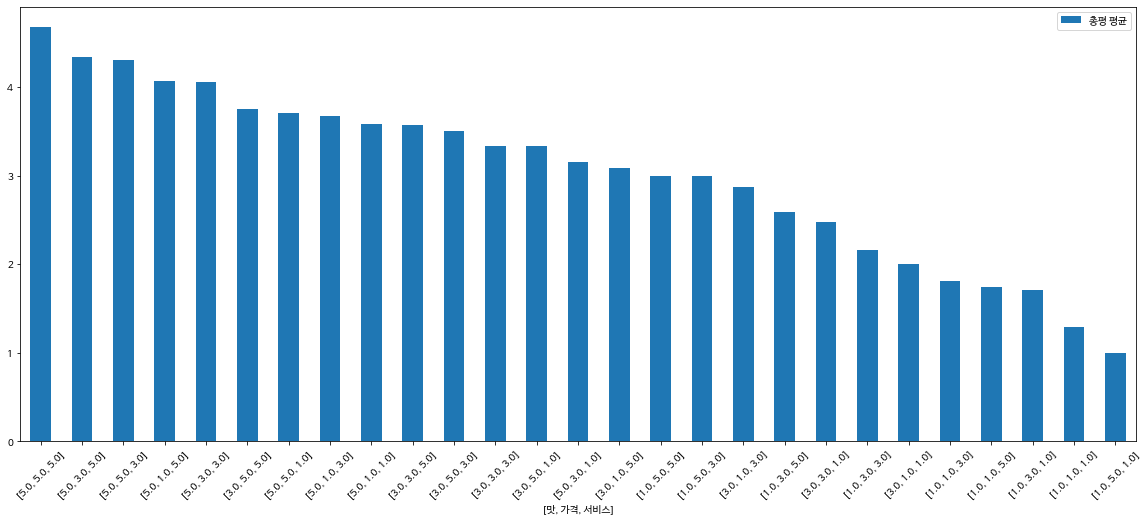

In [ ]:
# 맛평점, 가격평점, 서비스평점 3가지로 총평이 어떻게 변화할까?

Naming_List = []
Whole = []
for i in [1.0, 3.0, 5.0]:
    for j in [1.0, 3.0, 5.0]:
        for k in [1.0, 3.0, 5.0]:
            Naming_List.append([i, j, k])
            Whole.append(eda_df[(eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k)]['총평'].sum() / ((eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k)).sum())

Visual_Object = pd.DataFrame({'[맛, 가격, 서비스]':Naming_List,
                            '총평 평균':Whole})

Visual_Object.sort_values(by=['총평 평균'],ascending=False).plot.bar(x='[맛, 가격, 서비스]', y='총평 평균', rot=45, figsize=(20,8))

앞선 평균들과는 다르게 의미있어 보인다.

In [ ]:
# 맛평점, 가격평점, 서비스평점 3가지로 총평이 어떻게 변화할까?

Naming_List = []
Whole_1 = []
Whole_2 = []
Whole_3 = []
Whole_4 = []
Whole_5 = []
for i in [1.0, 3.0, 5.0]:
    for j in [1.0, 3.0, 5.0]:
        for k in [1.0, 3.0, 5.0]:
            Naming_List.append([i, j, k])
            Whole_1.append(((eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k) & (eda_df['총평'] == 1.0)).sum())
            Whole_2.append(((eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k) & (eda_df['총평'] == 2.0)).sum())
            Whole_3.append(((eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k) & (eda_df['총평'] == 3.0)).sum())
            Whole_4.append(((eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k) & (eda_df['총평'] == 4.0)).sum())
            Whole_5.append(((eda_df['맛평점'] == i) & (eda_df['가격평점'] == j) & (eda_df['서비스평점'] == k) & (eda_df['총평'] == 5.0)).sum())

Visual_Object = pd.DataFrame({'[맛, 가격, 서비스]':Naming_List,
                            '총평1점':Whole_1,
                            '총평2점':Whole_2,
                            '총평3점':Whole_3,
                            '총평4점':Whole_4,
                            '총평5점':Whole_5})
Visual_Object

,"[맛, 가격, 서비스]",총평1점,총평2점,총평3점,총평4점,총평5점
0,"[1.0, 1.0, 1.0]",30,10,1,0,0
1,"[1.0, 1.0, 3.0]",13,23,5,0,0
2,"[1.0, 1.0, 5.0]",7,10,2,0,0
3,"[1.0, 3.0, 1.0]",11,10,2,1,0
4,"[1.0, 3.0, 3.0]",6,26,13,0,0
5,"[1.0, 3.0, 5.0]",0,5,7,0,0
6,"[1.0, 5.0, 1.0]",1,0,0,0,0
7,"[1.0, 5.0, 3.0]",0,1,3,1,0
8,"[1.0, 5.0, 5.0]",1,0,3,0,1
9,"[3.0, 1.0, 1.0]",11,15,11,0,0


올 5점 주고 총평 1점 날린 ㅅㄲ는 뭐지

좋은 성능을 위해서는 저렇게 노답 case를 row drop하는 강경진압을 해야겠네요.

맛, 가격, 서비스 점수 합을 계산한 다음 총평과 멀리 떨어져있다면 row 삭제하는 계획을 설계해본다. AI 예측 모델에서 특정 인물의 돌+I성을 포용하기란 현대 기술로는 불가능합니다. so 저 3가지 점수 중 하나가 1, 3점이라고 나머지 두 개 5점 줬는데도 총평을 1, 2점 박아버리는 것은 개인의 취향일 뿐이다. 강력한 취향. therefore 과감한 삭제는 모델 성능 자체를 끌어올릴 수 있는 효과를 가져옵니다.

For example, 맛/가격/서비스 5 5 5 준 사람이 있다. 이 사람은 그 가게에서 다른 모든 부분이 좋았는데 옆 테이블에 조두순+이은해+강호순을 목격했다는 이유로 총평 1점을 줌

In [ ]:
# AI 산출점수는 총평에 반영될까? 다른 점수들도 확인해보자.

AI_Score = []
Whole_score = []
Taste_score = []
Pay_score = []
Service_score = []
for i in sorted(eda_df['AI산출점수'].unique()):
    AI_Score.append(i)
    Whole_score.append(eda_df[(eda_df['AI산출점수'] == i)]['총평'].sum() / (eda_df['AI산출점수'] == i).sum())
    Taste_score.append(eda_df[(eda_df['AI산출점수'] == i)]['맛평점'].sum() / (eda_df['AI산출점수'] == i).sum())
    Pay_score.append(eda_df[(eda_df['AI산출점수'] == i)]['가격평점'].sum() / (eda_df['AI산출점수'] == i).sum())
    Service_score.append(eda_df[(eda_df['AI산출점수'] == i)]['서비스평점'].sum() / (eda_df['AI산출점수'] == i).sum())

Visual_Object = pd.DataFrame({'AI의 점수':AI_Score,
                            '총평 평균':Whole_score,
                            '맛 평균':Taste_score,
                            '가격 평균':Pay_score,
                            '서비스 평균':Service_score})
Visual_Object

,AI의 점수,총평 평균,맛 평균,가격 평균,서비스 평균
0,16,3.600000,3.800000,3.400000,4.600000
1,19,5.000000,5.000000,5.000000,5.000000
2,33,2.750000,3.000000,3.500000,3.500000
3,34,2.400000,3.000000,3.000000,2.600000
4,35,2.600000,2.800000,2.400000,2.600000
5,36,3.062500,3.500000,3.375000,3.750000
6,37,3.000000,3.666667,3.000000,3.500000
7,38,3.047619,3.476190,3.476190,3.190476
8,39,3.682081,4.063584,3.346821,3.832370
9,40,3.839181,4.163743,3.555556,3.994152


평균 낸 것들 중에서는 처음으로 이상한 걸 빠르게 발견할 수 있다 : AI 점수 19점인데 점수 옆에를 봐라! 5가 4개다!

In [ ]:
# AI 산출점수는 총평에 반영될까? 다른 점수들도 확인해보자.

AI_Score = []
총평1_개수 = []
총평2_개수 = []
총평3_개수 = []
총평4_개수 = []
총평5_개수 = []
맛1_개수 = []
가격1_개수 = []
서비스1_개수 = []
맛3_개수 = []
가격3_개수 = []
서비스3_개수 = []
맛5_개수 = []
가격5_개수 = []
서비스5_개수 = []
for i in sorted(eda_df['AI산출점수'].unique()):
    AI_Score.append(i)
    총평1_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['총평'] == 1.0)).sum())
    총평2_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['총평'] == 2.0)).sum())
    총평3_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['총평'] == 3.0)).sum())
    총평4_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['총평'] == 4.0)).sum())
    총평5_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['총평'] == 5.0)).sum())
    맛1_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['맛평점'] == 1.0)).sum())
    가격1_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['가격평점'] == 1.0)).sum())
    서비스1_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['서비스평점'] == 1.0)).sum())
    맛3_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['맛평점'] == 3.0)).sum())
    가격3_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['가격평점'] == 3.0)).sum())
    서비스3_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['서비스평점'] == 3.0)).sum())
    맛5_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['맛평점'] == 5.0)).sum())
    가격5_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['가격평점'] == 5.0)).sum())
    서비스5_개수.append(((eda_df['AI산출점수'] == i) & (eda_df['서비스평점'] == 5.0)).sum())

Visual_Object = pd.DataFrame({'AI의 점수':AI_Score,
                            '총평 1점':총평1_개수,'총평 2점':총평2_개수,'총평 3점':총평3_개수,'총평 4점':총평4_개수,'총평 5점':총평5_개수,
                            '맛 1점':맛1_개수,'맛 3점':맛3_개수,'맛 5점':맛5_개수,
                            '가격 1점':가격1_개수,'가격 3점':가격3_개수,'가격 5점':가격5_개수,
                            '서비스 1점':서비스1_개수,'서비스 3점':서비스3_개수,'서비스 5점':서비스5_개수})
Visual_Object

,AI의 점수,총평 1점,총평 2점,총평 3점,총평 4점,총평 5점,맛 1점,맛 3점,맛 5점,가격 1점,가격 3점,가격 5점,서비스 1점,서비스 3점,서비스 5점
0,16,0,0,2,3,0,0,3,2,1,2,2,0,1,4
1,19,0,0,0,0,2,0,0,2,0,0,2,0,0,2
2,33,0,1,3,0,0,0,4,0,0,3,1,0,3,1
3,34,1,1,3,0,0,1,3,1,1,3,1,2,2,1
4,35,2,1,6,1,0,2,7,1,3,7,0,2,8,0
5,36,0,2,11,3,0,3,6,7,1,11,4,0,10,6
6,37,1,3,4,3,1,2,4,6,2,8,2,1,7,4
7,38,0,3,14,4,0,1,14,6,1,14,6,3,13,5
8,39,5,13,51,67,37,10,61,102,27,89,57,10,81,82
9,40,4,10,99,153,76,9,125,208,30,187,125,3,166,173


AI 19점이 1개가 아니었네. 2개였네!

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


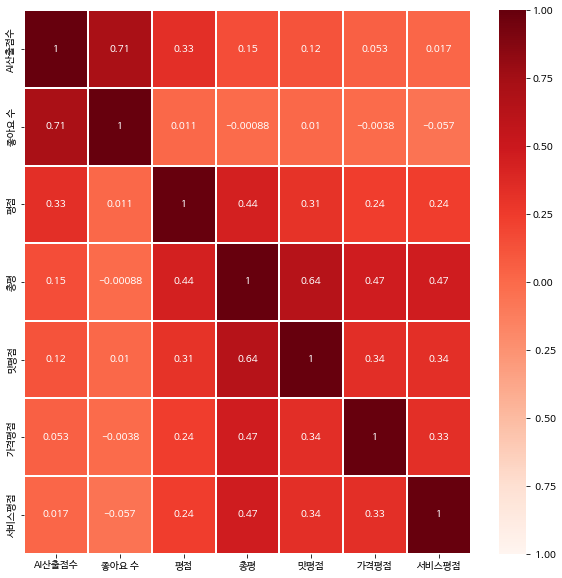

In [ ]:
# 기본 numbering되어있는 것들(=AI산출점수, 평점, 좋아요 수, 총평, 맛평점, 가격평점, 서비스평점)끼리 heatmap을 그려보자

corr_only = eda_df[['AI산출점수','좋아요 수','평점','총평','맛평점','가격평점','서비스평점']]
plt.figure(figsize=(10,10))
sns.heatmap(corr_only.corr(),vmin=-1,vmax=1,annot=True,linewidths=1.0,cmap='Reds')
plt.show()

1. AI는 좋아요 수의 장난감일 뿐이다.
2. 총평이랑 연관이 가장 큰 것은 맛평점이다. 그 뒤를 가격평점이랑 서비스평점이 같은 score로 따르고 있다. 그 뒤는 0.03 차이로 평점이 있다.
3. 우리의 예상대로 좋아요 수는 총평과 모르는 사이다.
4. 근데 test(시험 문제)에는 맛/가격/서비스평점이 없네요? 망했어요.

In [ ]:
for i in ['혼밥','데이트','식사모임','가족외식','회식']:
    print('{}의 개수 :'.format(i),(eda_df['방문목적'].str.contains(i)).sum())

혼밥의 개수 : 2181
데이트의 개수 : 3540
식사모임의 개수 : 2000
가족외식의 개수 : 551
회식의 개수 : 1003


회식만 해도 1000개가 넘네요. 가족외식은 빼고, 나머지 4개를 가지고 0과 1로 되어있는 새로운 column을 만들어보기로 해요. 식사 목적에 따라 인간들의 사고 방식이 달라지거든요.

## 4. 중간 단계

***이상으로 여러 가지 것들에 대한 데이터 분석을 진행해보았습니다.***

아래 모델링으로 넘어가기 전에, model_df = eda_df.copy()한 다음 model_df를 가지고 다음을 한다 : 

어떤 식당ID에 대해서 해당하는 총평에 얼마를 더하기/빼기/곱하기/나누기를 해서 값을 변경한다. 이 때 5 초과 또는 1 미만일 경우 그 값들은 5 또는 1로 지정하게 한다. 이 과정을 리뷰 작성자/시설(.str 이용)/체인점/AI 산출점수...에 대해서도 시도해 본다.

이 과정이 완료되었다면 data_patch = model_df.copy()를 해서 아래로 넘어가자.

In [ ]:
model_df = eda_df.copy()

In [ ]:
# 맛/가격/서비스 평점 합 k. [k=3 : 총평=3,4,5], [k=5 : 총평=4,5], [k=7 : 총평=5], [k=11 : 총평=1], [k=13 : 총평=1,2], [k=15 : 총평=1,2,3] row 삭제
# 맛 + 가격 + 서비스 = n일 때, n에서 3을 뺀 뒤 2로 나눈 값을 r이라고 하자. r과 총평의 차이가 3 이상이면 삭제하는 규칙
Delete_List_1 = model_df[abs((((model_df['맛평점'] + model_df['가격평점'] + model_df['서비스평점']) - 3) // 2) - model_df['총평']) >= 3].index
model_df.drop(Delete_List_1, inplace=True)

# [AI산출점수 == 19], [AI산출점수 == 16 & 총평 == 4], [AI산출점수 == 94 & 총평 == 1], [AI산출점수 == 100 & 총평 == 1,2] row 삭제
Delete_List_2 = model_df[((model_df['AI산출점수'] == 16) & (model_df['총평'] == 4.0)) | (model_df['AI산출점수'] == 19) | ((model_df['AI산출점수'] == 94) & (model_df['총평'] == 1.0)) | ((model_df['AI산출점수'] == 100) & (model_df['총평'] <= 2.1))].index
model_df.drop(Delete_List_2, inplace=True)

# 지역 == 청담, 코엑스, 강남역, 강남, 가로수길, 압구정 : 총평 = 1이면 1, 아니면 0인 새로운 column 제작
valocal = [1, 0]
conditions_a = [
    ((model_df['지역'] == '청담') | (model_df['지역'] == '코엑스') | (model_df['지역'] == '가로수길') | (model_df['지역'] == '압구정') | (model_df['지역'].str.contains('강남'))) & (model_df['총평'] == 1),
    model_df['총평'] < 9999
]
model_df['값비싼'] = np.select(conditions_a, valocal)
conditions_b = [
    ((test['지역'] == '청담') | (test['지역'] == '코엑스') | (test['지역'] == '가로수길') | (test['지역'] == '압구정') | (test['지역'].str.contains('강남'))) & (test['총평'] == 1),
    test['총평'] < 9999
]
test['값비싼'] = np.select(conditions_b, valocal)

# 시설.str.contains('발렛')에 해당하는 총평이 1이면 2, 2이면 1, 아니면 0인 새로운 column 제작
vals = [2, 1, 0]
conditions_1 = [
    model_df['시설'].str.contains('발렛') & model_df['총평'] == 1,
    model_df['시설'].str.contains('발렛') & model_df['총평'] == 2,
    model_df['총평'] < 9999
]
model_df['발렛 유무'] = np.select(conditions_1, vals)
conditions_2 = [
    test['시설'].str.contains('발렛') & test['총평'] == 1,
    test['시설'].str.contains('발렛') & test['총평'] == 2,
    test['총평'] < 9999
]
test['발렛 유무'] = np.select(conditions_2, vals)

# 방문목적.str.contains(혼밥, 데이트, 식사모임, 회식)에 따른 0과 1로 이루어진 새로운 column 제작
model_df['혼밥'] = np.where(model_df['방문목적'].str.contains('혼밥'), 1, 0)
model_df['데이트'] = np.where(model_df['방문목적'].str.contains('데이트'), 1, 0)
model_df['식사모임'] = np.where(model_df['방문목적'].str.contains('식사모임'), 1, 0)
model_df['회식'] = np.where(model_df['방문목적'].str.contains('회식'), 1, 0)
test['혼밥'] = np.where(test['방문목적'].str.contains('혼밥'), 1, 0)
test['데이트'] = np.where(test['방문목적'].str.contains('데이트'), 1, 0)
test['식사모임'] = np.where(test['방문목적'].str.contains('식사모임'), 1, 0)
test['회식'] = np.where(test['방문목적'].str.contains('회식'), 1, 0)

# 모델 씨 평점 column 여러 번 보셔요
model_df['평점copy'] = model_df['평점']
test['평점copy'] = test['평점']

# 리뷰 많이 한 사람만 뽑아서 0과 1로 이루어진 column 제작
model_df['리뷰많이한사람들'] = np.where( ((model_df['리뷰_작성자'] == 30305)|(model_df['리뷰_작성자'] == 16442)|(model_df['리뷰_작성자'] == 62542)|(model_df['리뷰_작성자'] == 17116)|(model_df['리뷰_작성자'] == 39228)|(model_df['리뷰_작성자'] == 90565)|(model_df['리뷰_작성자'] == 30701)), 1, 0)
test['리뷰많이한사람들'] = np.where( ((test['리뷰_작성자'] == 30305)|(test['리뷰_작성자'] == 16442)|(test['리뷰_작성자'] == 62542)|(test['리뷰_작성자'] == 17116)|(test['리뷰_작성자'] == 39228)|(test['리뷰_작성자'] == 90565)|(test['리뷰_작성자'] == 30701)), 1, 0)

# 체인점 있으면서 숫자 많은 스타벅스, 명동교자를 이용해서 이것들이면 1, 아니면 0인 column 제작
model_df['스타벅스'] = np.where(model_df['식당이름'].str.contains('스타벅스'), 1, 0)
model_df['명동교자'] = np.where(model_df['식당이름'].str.contains('명동교자'), 1, 0)
test['스타벅스'] = np.where(test['식당이름'].str.contains('스타벅스'), 1, 0)
test['명동교자'] = np.where(test['식당이름'].str.contains('명동교자'), 1, 0)

In [ ]:
data_patch = model_df.copy()

## 5. 모델링

In [ ]:
time_3 = time.time()

In [ ]:
# Train 데이터와 Test 데이터에서 '총평' 과 '리뷰_작성자' 는 삭제함.
# 노파심 is X_test는 절대 수정하면 안됩니다 이거 시험 문제인데 수정하면 '두려워져요'.
features = ['AI산출점수','평점','값비싼','발렛 유무','혼밥','데이트','식사모임','회식','평점copy','리뷰많이한사람들']
X_train_raw = data_patch[features]
X_test_raw = test[features]

# Train 데이터에서 '총평'만 떼네어서 y_train_raw 생성.
y_train_raw = data_patch['총평']

# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
RATIO = 0.1
X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_raw, test_size=RATIO, shuffle=True, random_state=RANDOM_SEED)
X_test = X_test_raw.copy()

def mae(y_truth, y_predict):
    return mean_absolute_error(y_truth, y_predict)

In [ ]:
X_train.shape, X_valid.shape

((7411, 10), (824, 10))

### 4.1. Random Forest

In [ ]:
rf_params = {'n_estimators': [200], 'max_features' : [10]}
# X_train.shape, X_valid.shape 결과값은 ((x, y), (u, v))다. y = v 성립해야 한다. 'max_features' : [n]에서 n = y = v 성립해야 한다.
# X_train.shape, X_valid.shape의 y랑 v가 baseline꺼에서 와장창했는데, 이 코드의 'max_features' : [n]만 바꾸면 아래는 다 된다더라.
rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_mean_absolute_error')
rf_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [10], 'n_estimators': [200]},
             scoring='neg_mean_absolute_error')

In [ ]:
col_cv_results = ['params', 'mean_test_score', 'rank_test_score']
pd.DataFrame(rf_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'max_features': 10, 'n_estimators': 200}",-0.655876,1


### 4.2. lightGBM

In [ ]:
lgb_params = {'num_leaves': [20], 'min_data': [60, 70], 'max_depth': [2], 'learning_rate': [0.05], 'n_estimators': [200, 300], 'sub_feature': [0.5], 'reg_alpha': [0.5], 'reg_lambda': [0.5]}
lgb_model = GridSearchCV(LGBMRegressor(boosting_type='gbdt'), param_grid=lgb_params, scoring='neg_mean_absolute_error')
lgb_model.fit(X_train, y_train)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05], 'max_depth': [2],
                         'min_data': [60, 70], 'n_estimators': [200, 300],
                         'num_leaves': [20], 'reg_alpha': [0.5],
                         'reg_lambda': [0.5], 'sub_feature': [0.5]},
             scoring='neg_mean_absolute_error')

In [ ]:
pd.DataFrame(lgb_model.cv_results_)[col_cv_results]

,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.584163,2
1,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.584458,4
2,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.583982,1
3,"{'learning_rate': 0.05, 'max_depth': 2, 'min_d...",-0.584284,3


### 4.3. 이후에 할 것들

In [ ]:
# 최적의 하이퍼파라미터로 학습된 모델을 저장합니다. 
best_rf = rf_model.best_estimator_
best_lgb = lgb_model.best_estimator_

# 학습용 데이터셋의 타깃 변수 예측 
y_pred_tr_rf = best_rf.predict(X_train)
y_pred_tr_lgb = best_lgb.predict(X_train)

# 검증용 데이터셋의 타깃 변수 예측
y_pred_va_rf = best_rf.predict(X_valid)
y_pred_va_lgb = best_lgb.predict(X_valid)

# 평가용 데이터셋의 타깃 변수 예측
y_pred_te_rf = best_rf.predict(X_test)
y_pred_te_lgb = best_lgb.predict(X_test)

In [ ]:
# 앙상블 모형의 학습 및 검증 데이터에 대한 타깃 변수 예측 
y_pred_tr_en= np.mean([y_pred_tr_rf, y_pred_tr_lgb], axis=0)
y_pred_va_en= np.mean([y_pred_va_rf, y_pred_va_lgb], axis=0)
y_pred_te_en= np.mean([y_pred_te_rf, y_pred_te_lgb], axis=0)

In [ ]:
# 학습 데이터셋의 MAE 계산 
mae_tr_rf = mae(y_train, y_pred_tr_rf)
mae_tr_lgb = mae(y_train, y_pred_tr_lgb)
mae_tr_en = mae(y_train, y_pred_tr_en)

# 검증 데이터셋의 MAE 계산 
mae_va_rf = mae(y_valid, y_pred_va_rf)
mae_va_lgb = mae(y_valid, y_pred_va_lgb)
mae_va_en = mae(y_valid, y_pred_va_en)

print(f'\n**** Random Forest\n')
print(f'Train MAE: {round(mae_tr_rf, 4)}\n')
print(f'Valid MAE: {round(mae_va_rf, 4)}')

print(f'\n**** LightGBM\n')
print(f'Train MAE: {round(mae_tr_lgb, 4)}\n')
print(f'Valid MAE: {round(mae_va_lgb, 4)}')

print(f'\n**** Ensemble\n\n')
print(f'Train MAE: {round(mae_tr_en, 4)}\n')
print(f'Valid MAE: {round(mae_va_en, 4)}')


**** Random Forest

Train MAE: 0.482

Valid MAE: 0.6961

**** LightGBM

Train MAE: 0.5801

Valid MAE: 0.6214

**** Ensemble


Train MAE: 0.5221

Valid MAE: 0.648


(0.0, 1.0)

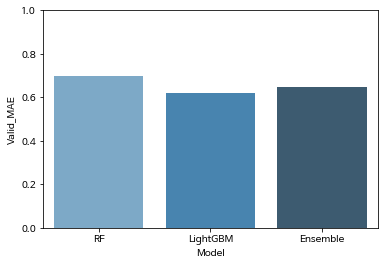

In [ ]:
mae_valid = [mae_va_rf, mae_va_lgb, mae_va_en]
recap_model = ['RF', 'LightGBM', 'Ensemble']
df_recap = pd.DataFrame({'Model': recap_model, 'Valid_MAE' : mae_valid})
ax = sns.barplot(x='Model', y='Valid_MAE', data=df_recap, palette="Blues_d")
ax.set_ylim([0.0, 1.0]) 

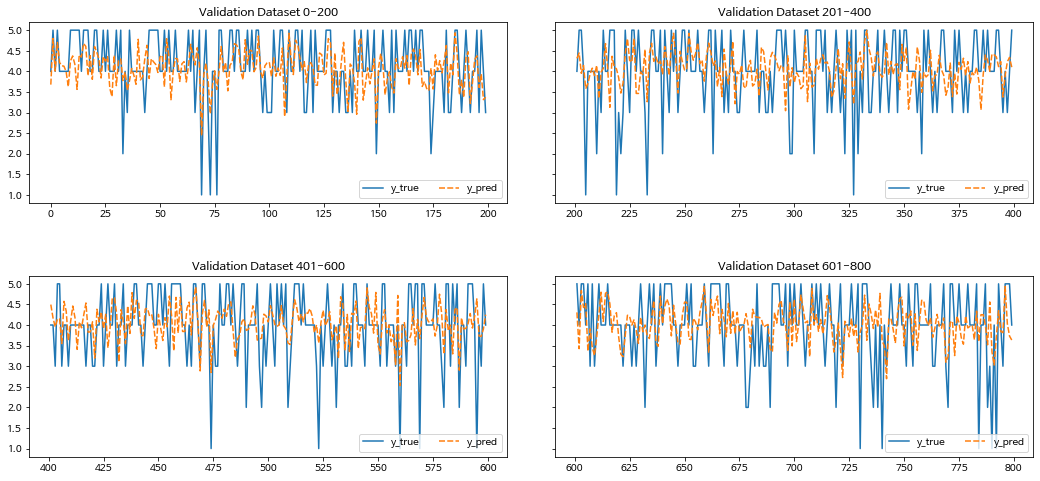

<Figure size 432x288 with 0 Axes>

In [ ]:
df_train = pd.DataFrame({'y_true': y_train.values, 'y_pred': y_pred_tr_en})
df_valid = pd.DataFrame({'y_true': y_valid.values, 'y_pred': y_pred_va_en})

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(18,4*2))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.lineplot(data = df_valid[0:200], ax=axes[0][0])
sns.lineplot(data = df_valid[201:400], ax=axes[0][1])
sns.lineplot(data = df_valid[401:600], ax=axes[1][0])
sns.lineplot(data = df_valid[601:800], ax=axes[1][1])


axes[0][0].set_title('Validation Dataset 0-200')
axes[0][1].set_title('Validation Dataset 201-400')
axes[1][0].set_title('Validation Dataset 401-600')
axes[1][1].set_title('Validation Dataset 601-800')

for i in range(2):
    axes[i][0].legend(loc='lower right', ncol=2)
    axes[i][1].legend(loc='lower right', ncol=2)

plt.show()
plt.clf() 

## 6. Submission 하기

In [ ]:
# 정수화 하고 나서 5보다 큰 값 또는 1보다 작은 값이 있는지 확인.

for n in np.around(y_pred_te_en):
    if n > 5:
        print(n)
    elif n < 1:
        print(n)

In [ ]:
# len(X_test) = len(submit)이어야만 가능합니다.
submit['총평'] = list(np.around(y_pred_te_en))

In [ ]:
submit.head()

,총평,Answer_ID
0,3.0,94354_38
1,4.0,63420_370
2,3.0,81264_2155
3,4.0,58332_2513
4,4.0,80349_8415


In [ ]:
now = datetime.datetime.now()
submit.to_csv(f'Submission_{now}.csv',encoding='utf-8', index=False)